# Dogs vs. Cats! Build Deep Neural Networks from scratch!

![](https://miro.medium.com/max/1500/1*36MELEhgZsPFuzlZvObnxA.gif)

## Introduction
This project will walk you through the process of building Deep Neural Networks (DNN) algorithms to predict dogs and cats from scratch (without using 3rd party libraries). The accuracy of this DNN will be compared to the one from SKLearn using Logistic Regression.


## Instalation
Please unzip data.zip file into data folder before running this jupyter notebook file.
Download data.zip: https://drive.google.com/file/d/1Mkqf8r_8mQLjUEsvkydGIoDxPIsXbb3Z/view?usp=sharing

## About the datasets
* The datasets contains train dataset (5000 images) and test dataset (500 images) - which are in __H5__ format. __H5__ is an efficience way to store data, and Python has a library __h5py__ for working with __H5__.
* The train and test dataset contain 2 keys: `images` (which contains training instances) and `labels` (which has 2 values: 0 represents dogs and 1 represents cats).

In [1]:
import pandas as pd
import h5py
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

np.random.seed(1)

## Load Datasets

In [2]:
def load_dataset():
    train_dataset = h5py.File('./data/catsvsdogs-train.h5', "r")
    train_set_x_orig = np.array(train_dataset["images"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["labels"][:]) # your train set labels

    test_dataset = h5py.File('./data/catsvsdogs-test.h5', "r")
    test_set_x_orig = np.array(test_dataset["images"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["labels"][:]) # your test set labels
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig

In [3]:
train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig = load_dataset()

### Convert BGR to RGB Images
As OpenCV was used to load the images that makes all images in BGR color mode. Hence, we need to convert the color mode back to RGB.

In [4]:
def convert_bgr_rgb(dataset):
  rgb_dataset = np.empty([len(dataset), dataset[1].shape[0], dataset[1].shape[1], dataset[1].shape[2]], dtype=np.int16)
  
  print(rgb_dataset.shape)
                          
  for i in range(0, len(dataset)):
    image = dataset[i]
    rgb_dataset[i] = image[:,:,::-1] # revert the color modes
  
  return rgb_dataset

train_set_x_rgb = convert_bgr_rgb(train_set_x_orig)
test_set_x_rgb = convert_bgr_rgb(test_set_x_orig)

(5000, 128, 128, 3)
(500, 128, 128, 3)


**Print out some test images**

Train dataset shape: (5000, 128, 128, 3)
Test dataset shape: (500, 128, 128, 3)


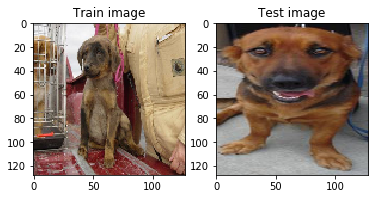

In [5]:
print("Train dataset shape:", train_set_x_rgb.shape)
print("Test dataset shape:", test_set_x_rgb.shape)

index_train = np.random.randint(0,len(train_set_x_rgb)) 
index_test = np.random.randint(0,len(test_set_x_rgb)) 

fig, axes = plt.subplots(nrows=1, ncols=2)

ax = axes.ravel()

ax[0].imshow(train_set_x_rgb[index_train], cmap='gray')
ax[0].set_title("Train image")

ax[1].imshow(test_set_x_rgb[index_test], cmap='gray')
ax[1].set_title("Test image")

plt.show()

### EDA

#### Explore some sample images

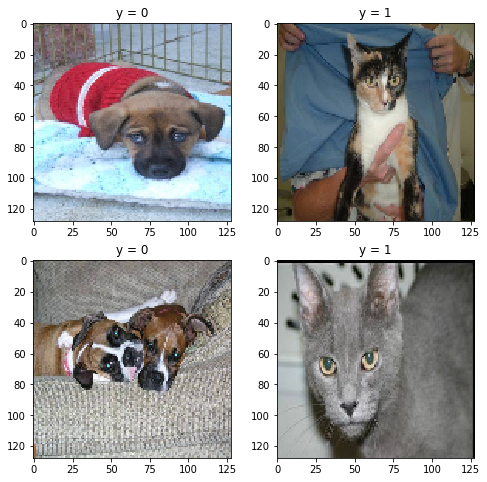

In [6]:
# Some some random images and their labels
plt.subplots(figsize = (8,8))
plt.subplot(221)
index_1 = np.random.randint(0,len(train_set_x_rgb)) 
train_set_y_orig[index_1]
plt.imshow(train_set_x_rgb[index_1])
plt.title("y = " + str(train_set_y_orig[index_1]))

plt.subplot(222)
index_2 = np.random.randint(0,len(train_set_x_rgb))
plt.imshow(train_set_x_rgb[index_2])
plt.title("y = " + str(train_set_y_orig[index_2]))

plt.subplot(223)
index_3 = np.random.randint(0,len(train_set_x_rgb))
plt.imshow(train_set_x_rgb[index_3])
plt.title("y = " + str(train_set_y_orig[index_3]))

plt.subplot(224)
index_4 = np.random.randint(0,len(train_set_x_rgb))
plt.imshow(train_set_x_rgb[index_4])
plt.title("y = " + str(train_set_y_orig[index_4]))

plt.show()

#### Classes distribution

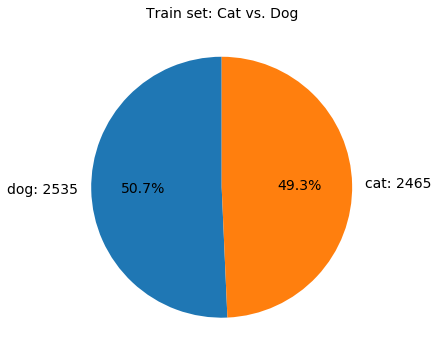

In [7]:
# Visualization the train set labels
unique, counts = np.unique(train_set_y_orig, return_counts = True)
dict1 = dict(zip(unique, counts))
plt.figure(figsize=(6,6))
plt.pie(x = counts, labels = ['dog: %s' % counts[0],'cat: %s' % counts[1]], autopct = '%1.1f%%', startangle=90, textprops={'fontsize': 14})
plt.title('Train set: Cat vs. Dog', fontdict={'fontsize': 14})
plt.show()

The dataset's classes seems to be balanced

## Implement deep neuron networks from scratch

In [8]:
def Sigmoid(z):
    return 1/(1 + np.exp(-z))

In [9]:
def Sigmoid_derivative(Z):
    s = 1/(1+np.exp(-Z))
    dZ = s * (1-s)
    return dZ

In [10]:
def Relu(Z):
    return np.maximum(0, Z)

In [11]:
def Relu_derivative(Z):
    temp = np.ones(Z.shape)
    temp[Z<0] = 0
    return temp

In [12]:
def Loss(y, y_hat):
    return np.sum((1./y.shape[1]) * (-np.multiply(y,np.log(y_hat)) - np.multiply(1-y, np.log(1-y_hat))))

In [13]:
def Init_layer(X, y, num_layer = 3, num_node = 108, method='randn', random_state = 1):    
    if random_state == 1:
        np.random.seed(1)

    param = {}
    dims = []
    dims.append(X.shape[1])
    for i in range(num_layer):
        dims.append(num_node)
    dims.append(y.shape[0])

    if method == 'randn':
        for i in range(1, num_layer+2):
            param['W'+str(i)] = np.random.randn(dims[i],dims[i-1]) / np.sqrt(dims[i-1]) 
            param['b'+str(i)] = np.random.randn(dims[i],1)                      
    elif method == 'normal':
        for i in range(1, num_layer+2):
            param['W'+str(i)] = np.random.normal(0, 1/y.shape[1], (dims[i],dims[i-1])) 
            param['b'+str(i)] = np.ones((dims[i],1))   

    return param, dims

In [14]:
def feed_forward(X, y, param, dims):
    ch = {}
    ch['A0'] = X.T
    k = len(dims) - 1

    for i in range(1, k+1):
        Z = param['W'+str(i)].dot(ch['A'+str(i-1)]) + param['b'+str(i)] 
        if i == k:
            A = Sigmoid(Z)
        else:
            A = Relu(Z)
        ch['Z'+str(i)],ch['A'+str(i)]=Z,A

    loss = Loss(y, ch['A'+str(k)])
    return ch, loss

In [26]:
def backward(y, ch, param, dims, lr, regularization = None):
    
    if regularization == 'l2':
        regu = 1
    else:
        regu = 0
        
    grad = {}
    k = len(dims) - 1
    m = y.shape[1]
    for i in range(1, k+1)[::-1]:
        if i == k:
            e = (ch['A'+str(k)] - y) / m 
        else:
            e = np.dot(param['W'+str(i+1)].T, grad['E'+str(i+1)]) * Relu_derivative(ch['Z'+str(i)])
        grad['E'+str(i)] = e
        grad['dW'+str(i)] = np.dot(e, ch['A'+str(i-1)].T) + 0.01 * param['W'+str(i)] * regu
        grad['db'+str(i)] = np.sum(e)

    return grad

In [16]:
def predict(X, y, param, dims):
  predictions = feed_forward(X, y, param, dims)[0]['A'+str(len(dims)-1)] >= 0.5
  return predictions

In [133]:
def deep_neural_net(X, y, num_hidden_layer = 4, hidden_node_per_layer = 35, iteration=3000, lr=0.1, batch_size=64, regulization=None, random_method='randn'):
    
    costs = []
    test_errors = []
    validation_errors = []
    reports = {}
    best_param = {}
    best_accuracy = 0
    
    # initialize parameters & neuron network layers
    param, dims = Init_layer(X_train, y_train, num_hidden_layer, hidden_node_per_layer, method=random_method)
    k = len(dims) - 1
    
    # start training
    for i in range(iteration):
        mini_batch = np.random.randint(0, X_train.shape[0], batch_size)
        X_batch = X_train[mini_batch, :]
        y_batch = y_train[0, mini_batch].reshape(1, -1)
        
        # forward & backward propagations
        ch, loss = feed_forward(X_batch, y_batch, param, dims)
        grad = backward(y_batch, ch, param, dims, lr, regularization=regularization)
        
        # update parameters
        for j in range(1, k+1):
            param['W'+str(j)] -= lr * grad['dW'+str(j)]
            param['b'+str(j)] -= lr * grad['db'+str(j)]
        
        # printing progress and prepare reports
        if i % 100 == 0:
            J_train = feed_forward(X_train, y_train, param, dims)[1]
            costs.append(J_train)
            print('Iteration: ',i, ' Loss: ', J_train)
            
            # predictions
            predicts = predict(X_validation, y_validation, param, dims)
            predicts_test = predict(X_test, y_test, param, dims) 
            
            # accuracy scores
            validation_accuracy = accuracy_score(y_validation.T, predicts.T)
            test_accuracy = accuracy_score(y_test.T, predicts_test.T)
            print('Validation accuracy score: ', validation_accuracy)
            
            # calculate errors
            validation_error = 1 - validation_accuracy
            validation_errors.append(validation_error)
            test_error = 1 - test_accuracy
            test_errors.append(test_error)
                                           
            # Save our best parameters
            if (validation_accuracy > best_accuracy):
                best_accuracy = validation_accuracy
                best_param = param
                reports['validation_accuracy'] = validation_accuracy
                reports['test_accuracy'] = test_accuracy
                reports['predicts'] = predicts
                reports['predicts_test'] = predicts_test
            print('best_accuracy: ', best_accuracy)
        
        # adjust learning rate for better accuracy
        if ((i%500 == 0) & (lr > 0.0001)):
            lr /= 2  
    
    reports['costs'] = costs                                 
    reports['validation_errors'] = validation_errors
    reports['test_errors'] = test_errors
  
    return best_param, reports

### Model training & hyper-parameters training

#### Training model in batch
As training more than 3000 images is an exhausive work and take a lot of time, we train our model in batch, which means for each iteration, we will randomly select a small number of images from the dataset as train data (batch). By doing so, we still maintain our accuracy while reducing training time significantly.

In [130]:
# Convert X to 2D array
X_train = train_set_x_rgb.flatten().reshape((len(train_set_x_rgb),-1)) / 255
X_test = test_set_x_rgb.flatten().reshape((len(test_set_x_rgb),-1)) / 255

# Convert y to 1D array
y_train = train_set_y_orig.reshape(1, -1)
y_test = test_set_y_orig.reshape(1, -1)

In [131]:
# initialize train datasets
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train.T, test_size=0.2)
y_train = y_train.reshape(1, -1)
y_validation = y_validation.reshape(1, -1)

# initialize test datasets
X_test = test_set_x_rgb.flatten().reshape((len(test_set_x_rgb),-1)) / 255
y_test = test_set_y_orig.reshape(1, -1)

In [132]:
# num_hidden_layer = 5, hidden_node_per_layer = 50, iteration = 2001, learning_rate = 0.05, batch_size = 128, regularization = 'l2' => train acc: 0.77, test acc: 0.642
num_hidden_layer = 5
hidden_node_per_layer = 50
iteration = 3001
learning_rate = 0.06
batch_size = 128
regularization = 'l2'
random_method = 'randn'

best_param, reports = deep_neural_net(X_train, y_train, num_hidden_layer, hidden_node_per_layer, iteration, learning_rate, batch_size, regularization, random_method)

Iteration:  0  Loss:  0.7698186573909305
Validation accuracy score:  0.487
best_accuracy:  0
Iteration:  100  Loss:  0.6862434739370165
Validation accuracy score:  0.539
best_accuracy:  0.487
Iteration:  200  Loss:  0.6687279290127095
Validation accuracy score:  0.586
best_accuracy:  0.539
Iteration:  300  Loss:  0.6640468666401429
Validation accuracy score:  0.583
best_accuracy:  0.586
Iteration:  400  Loss:  0.7050139055623184
Validation accuracy score:  0.513
best_accuracy:  0.586
Iteration:  500  Loss:  0.6718695095147809
Validation accuracy score:  0.566
best_accuracy:  0.586
Iteration:  600  Loss:  0.6265142612214644
Validation accuracy score:  0.587
best_accuracy:  0.586
Iteration:  700  Loss:  0.6217557682131392
Validation accuracy score:  0.601
best_accuracy:  0.587
Iteration:  800  Loss:  0.6189197783532885
Validation accuracy score:  0.582
best_accuracy:  0.601
Iteration:  900  Loss:  0.6059405229064134
Validation accuracy score:  0.608
best_accuracy:  0.601
Iteration:  1000

### Visualize results

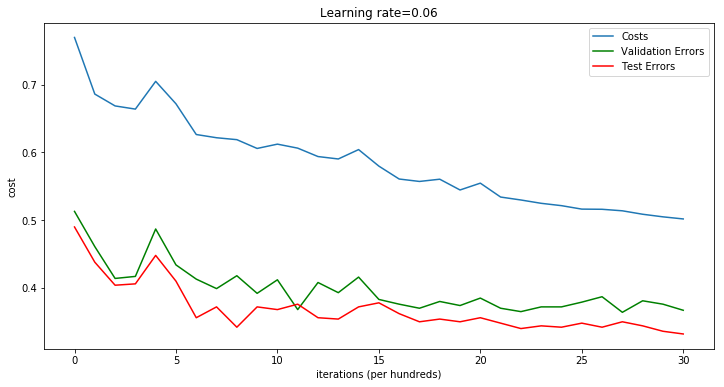

Accuracy Score - Training set: 0.633000
Confusion Matrix:
[[323 164]
 [203 310]]


Accuracy Score - Test set: 0.668000
Confusion Matrix:
[[167  88]
 [ 78 167]]


In [138]:
# plot the cost
fig, ax = plt.subplots(figsize=[12, 6])
line_costs, = plt.plot(reports['costs'])
line_val_errors, = plt.plot(reports['validation_errors'], c='g')
line_test_errors, = plt.plot(reports['test_errors'], c='r')
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title('Learning rate=' + str(learning_rate) )
plt.legend([line_costs, line_val_errors, line_test_errors], ['Costs', 'Validation Errors', 'Test Errors'])
plt.show()

# show accuracy scores
param, dims = Init_layer(X_validation, y_validation, num_hidden_layer, hidden_node_per_layer, method=random_method)
predictions = predict(X_validation, y_validation, best_param, dims)
print("Accuracy Score - Training set: %f" % accuracy_score(y_validation[0], predictions[0]))
print("Confusion Matrix:")
print(confusion_matrix(y_validation[0], predictions[0]))
print('\n')
test_predictions = predict(X_test, y_test, best_param, dims)
print("Accuracy Score - Test set: %f" % accuracy_score(y_test[0], test_predictions[0]))
print("Confusion Matrix:")
print(confusion_matrix(y_test[0], test_predictions[0]))

### Save our model

In [135]:
# Save best param to file
import pickle
import os

pickle.dump(best_param, open(os.path.join('models', 'Model_DNN_cats_vs_dogs_acc_633.pkl'), 'wb'), protocol=4)
pickle.dump(reports, open(os.path.join('models', 'Reports_DNN_cats_vs_dogs_acc_633.pkl'), 'wb'), protocol=4)

In [136]:
model_dnn_params = pickle.load(open('./models/Model_DNN_cats_vs_dogs_acc_633.pkl', 'rb'))
model_dnn_reports = pickle.load(open('./models/Reports_DNN_cats_vs_dogs_acc_633.pkl', 'rb'))

In [137]:
param, dims = Init_layer(X_train, y_train, num_hidden_layer, hidden_node_per_layer, method=random_method)
predictions = predict(X_validation, y_validation, model_dnn_params, dims)
print("Accuracy Score - Training set: %f" % accuracy_score(y_validation[0], predictions[0]))
print("Confusion Matrix:")
print(confusion_matrix(y_validation[0], predictions[0]))
print('\n')
test_predictions = predict(X_test, y_test, model_dnn_params, dims)
print("Accuracy Score - Test set: %f" % accuracy_score(y_test[0], test_predictions[0]))
print("Confusion Matrix:")
print(confusion_matrix(y_test[0], test_predictions[0]))

Accuracy Score - Training set: 0.633000
Confusion Matrix:
[[323 164]
 [203 310]]


Accuracy Score - Test set: 0.668000
Confusion Matrix:
[[167  88]
 [ 78 167]]


### Print Mislabeled Images

In [139]:
def print_mislabeled_images(X, y, p):
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (200.0, 200.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    print('Total mislabels:', num_images)
    
    random_mislabels = np.random.randint(0, num_images, 6)
    j = 0
    for i in random_mislabels:
        index = mislabeled_indices[1][i]
    
        plt.subplot(2, num_images//2, j + 1)
        plt.imshow(X[index, :].reshape(128,128,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + str(int(p[0,index])) + " \n Actual: " + str(y[0,index]))
        
        j += 1

Total mislabels: 166


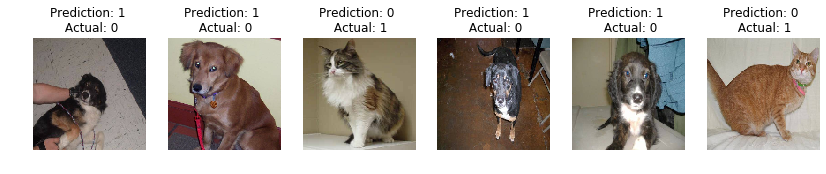

In [140]:
print_mislabeled_images(X_test, y_test, test_predictions)

## Model from sklearn

In [23]:
# Create Logistics Regression model from X and y
lg = LogisticRegression()
lg.fit(X_train, y_train[0])

# Show metrics
print("Accuracy Score: %f" % accuracy_score(y_test[0], lg.predict(X_test)))
print("Confusion Matrix:")
print(confusion_matrix(y_test[0], lg.predict(X_test)))

Accuracy Score: 0.598000
Confusion Matrix:
[[137 118]
 [ 83 162]]


## Conclusion

* Using deep neural networks, our model's accuracy is better than the one using Logistic Regression from sklearn.
* However, the accuracy stays within 60-67% range and cannot reach 70%. We can improve our model by adding more layers, i.e Convolution layer (CNN)
* For better scalability, we can refactor our code into Object Oriented Programming (OOP) structure.